#  Приоритизация гипотез и анализ A/B-теста для интернет-магазина

### Описание проекта
Задача: дан список гипотез для увеличения выручки, подготовленных совместно с отделом маркетинга.  
Требуется:
-	приоритизировать гипотезы,
- запустить A/B-тест,
- проанализировать результаты.



## Содержание
- [Библиотеки](#libraries)  
- [1. Знакомство с данными ](#dataintro)  
- [2. Предобработка данных](#datacleaning)    
- [3. Работа с данными](#analysis)
    - [3.1. Часть 1. Приоретизация гипотез](#part1)
    - [3.2. Часть 2. Анализ A/B-теста](#part2)
- [4. Общий вывод](#conclusion)

### Библиотеки <a name="libraries"></a>

In [1]:
# Импорт нужных библиотек
import pandas as pd
import matplotlib.pyplot as plt 
from math import factorial 
from scipy import stats as st 
import scipy.stats as stats
import numpy as np  

## 1. Знакомство с данными <a name="dataintro"></a>

#### Описание данных
Файл /datasets/hypothesis.csv содержит следующие данные:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv содержит следующие данные:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv содержит следующие данные:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [2]:
# создадим функцию, которая выводит название датасета, его info, количество пропусков в каждом столбце и число дублирующихся строк
def info_nans_doubles(df):
    name =[x for x in globals() if globals()[x] is df][0] # вытаскиваем наименование датафрейма
    print('Информация о датафрейме {}\n'.format(name))
    print(df.info())
    print('--------------------------------------------')
    for i in df.columns:
        print('Число пропущенных значений в столбце ', i, ' = ', df[i].isnull().sum())
    print('--------------------------------------------')
    print('Число дубликатов в датафрейме {}'.format(name), df.duplicated().sum())

In [3]:
# читаем файлы и знакомимся с ними по 5 случайным строкам
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.sample(5)

,Hypothesis,Reach,Impact,Confidence,Efforts
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
7,Добавить форму подписки на все основные страни...,10,7,8,5
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [4]:
# применяя функцию info_nans_doubles, изучаем информацию о таблице
info_nans_doubles(hypothesis)

Информация о датафрейме hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
--------------------------------------------
Число пропущенных значений в столбце  Hypothesis  =  0
Число пропущенных значений в столбце  Reach  =  0
Число пропущенных значений в столбце  Impact  =  0
Число пропущенных значений в столбце  Confidence  =  0
Число пропущенных значений в столбце  Efforts  =  0
--------------------------------------------
Число дубликатов в датафрейме hypothesis 0


In [5]:
orders = pd.read_csv('/datasets/orders.csv')
orders.sample(5)

,transactionId,visitorId,date,revenue,group
1159,29438557,1637811943,2019-08-14,3470,B
536,3925488023,3984495233,2019-08-04,20219,A
1190,38478481,1197745035,2019-08-14,8600,B
745,648682471,2633052872,2019-08-27,4900,A
597,831316805,3511617963,2019-08-26,7995,B


In [6]:
# применяя функцию info_nans_doubles, изучаем информацию о таблице
info_nans_doubles(orders)

Информация о датафрейме orders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
--------------------------------------------
Число пропущенных значений в столбце  transactionId  =  0
Число пропущенных значений в столбце  visitorId  =  0
Число пропущенных значений в столбце  date  =  0
Число пропущенных значений в столбце  revenue  =  0
Число пропущенных значений в столбце  group  =  0
--------------------------------------------
Число дубликатов в датафрейме orders 0


In [7]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.sample(5)

,date,group,visitors
42,2019-08-12,B,543
13,2019-08-14,A,735
38,2019-08-08,B,654
6,2019-08-07,A,644
30,2019-08-31,A,699


In [8]:
# применяя функцию info_nans_doubles, изучаем информацию о таблице
info_nans_doubles(visitors)

Информация о датафрейме visitors

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
--------------------------------------------
Число пропущенных значений в столбце  date  =  0
Число пропущенных значений в столбце  group  =  0
Число пропущенных значений в столбце  visitors  =  0
--------------------------------------------
Число дубликатов в датафрейме visitors 0


### Вывод
Необходимо в датафрейме hypothesis привести названия столбцов к строчному виду.  
В остальном предобработка не требуется.

## 2. Предобработка данных <a name="datacleaning"></a>

In [9]:
#приведем названия столбцов к строчному виду в hypothesis
hypothesis.columns = hypothesis.columns.str.lower()

# 3. Работа с данными <a name="analysis"></a>

## Часть 1. Приоритизация гипотез. <a name="part1"></a>

In [10]:
# Применим фреймворк ICE для приоритизации гипотез
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False) #Отсортируем их по убыванию приоритета

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


Наиболее перспективные гипотезы по ICE: 8, 0, 7, 6.


In [11]:
# Применим фреймворк RICE для приоритизации гипотез
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False) #Отсортируем их по убыванию приоритета

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


Наиболее перспективные гипотезы по RICE: 7, 2, 0, 6.

In [12]:
# напечатаем формулировки выбранных гипотез
print(hypothesis['hypothesis'][7])
print(hypothesis['hypothesis'][0])

Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей


## Вывод 
Наиболее перспективные гипотезы по RICE: **7, 2, 0**.  
Наиболее перспективные гипотезы по ICE: **8, 0, 7**.  

Отбросим гипотезу с индексом 8, так как, из-за ее низкого охвата, она не даст значимых результатов.  
Гипотеза 2 не вошла в топ по ICE потому что, не смотря на высокий охват, ее влияние недостаточно велико.  

Рекомендуемые для тестирования гипотезы (с индексами 7 и 0):  
**- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**;  
**- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей**.

## Часть 2. Анализ A/B-теста <a name="part2"></a>


Проанализируем полученные результаты A/B-теста.

In [13]:
# Создадим таблицу с аккумулированными по дням и тестовым группам данными о посетителях, покупателях и покупках.

# создаем массив уникальных пар значений дат и групп теста:
datesGroups = orders[['date','group']].drop_duplicates()

# получим агрегированные кумулятивные по дням данные о покупателях и покупах:
orders_aggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                                     orders['group'] == x['group'])]\
.agg({'date':'max', 'group':'max', 'transactionId':'nunique', 'visitorId':'nunique', 'revenue':'sum'}), axis=1)\
.sort_values(by=['date','group'])

# Аналогично, получим агрегированные кумулятивные по дням данные о посетителях:
visitors_aggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                                          visitors['group'] == x['group'])]\
                                        .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
                                        .sort_values(by=['date','group'])

# объединим кумулятивные данные в одной таблице и присваивоим ее столбцам понятные названия:
cummulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date','group'], right_on=['date','group'])
cummulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cummulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


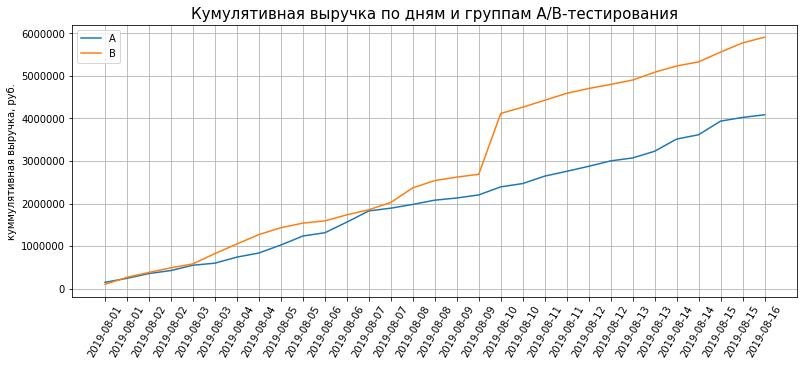

In [14]:
# Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
a_cum_rev = cummulative_data[cummulative_data['group']=='A'][['date','revenue', 'orders']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
b_cum_rev = cummulative_data[cummulative_data['group']=='B'][['date','revenue', 'orders']]

# Строим график
figure, ax = plt.subplots(figsize=(13, 5))
ax.plot(a_cum_rev['date'], a_cum_rev['revenue'], label='A') # график выручки группы А
ax.plot(b_cum_rev['date'], b_cum_rev['revenue'], label='B') # график выручки группы B
ax.set_title('Кумулятивная выручка по дням и группам A/B-тестирования', fontsize='15')
ax.set_xticklabels(cummulative_data['date'], rotation=60) # вертим даты по оси x
ax.set_ylabel('куммулятивная выручка, руб.')
ax.grid(True)
plt.legend(); # добавляем легенду

Выручка почти равномерно увеличивается в течение всего теста. 

Видим, что после 3 августа куммулятивная выручка в группе B стала превосходить выручку группы А.  
К 7 августа их показатели сравнялись из-за рывка в группе A в течение 6-7 августа. Однако после этого скачки в росте выручки группы B (в особенности произошедший 9 августа) закрепили превосходство показателя группы B. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. 

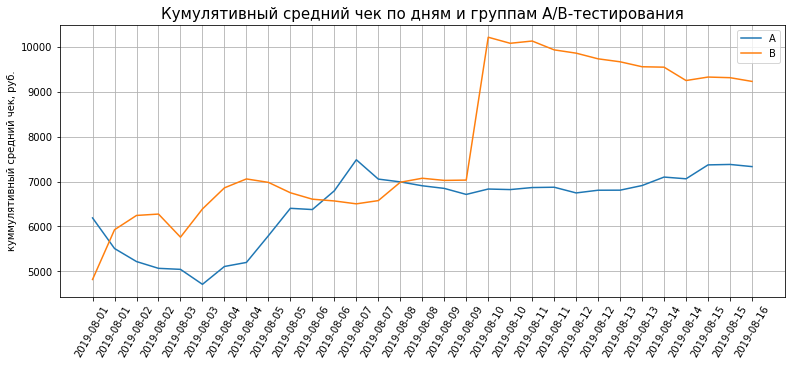

In [15]:
# Построим график кумулятивного среднего чека по группам
figure, ax = plt.subplots(figsize=(13, 5))
ax.set_title('Кумулятивный средний чек по дням и группам A/B-тестирования', fontsize=15)
ax.plot(a_cum_rev['date'], a_cum_rev['revenue']/a_cum_rev['orders'], label='A')
ax.plot(b_cum_rev['date'], b_cum_rev['revenue']/b_cum_rev['orders'], label='B')
ax.set_xticklabels(cummulative_data['date'], rotation=60)
ax.set_ylabel('куммулятивный средний чек, руб.')
ax.grid(True)
ax.legend();

Средний чек в обеих группах колеблется и растет до 7-9 августа.  
Для **группы A** средний чек более или менее установился после 7 августа в районе около 7,000 руб., дальнейшие колебания не сильные.  
*9 августа* в **группе B** произошел резкий скачок показателя, после этого он стал немного снижаться, хотя куммулятивная метрика осталась выше, чем у группы А. Возможно, в группу B в этот день попали крупные заказы. Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

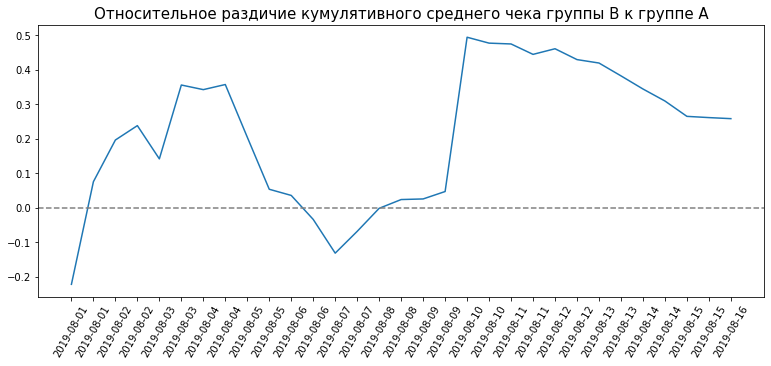

In [16]:
# Построим график относительного изменения кумулятивного среднего чека группы B к группе A

# собираем данные в одном датафрейме
merged_cum_rev = a_cum_rev.merge(b_cum_rev, left_on='date', right_on='date', how='left', suffixes=['_A', '_B'])

# строим отношение средних чеков
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(merged_cum_rev['date'], (merged_cum_rev['revenue_B']/merged_cum_rev['orders_B'])/\
                                 (merged_cum_rev['revenue_A']/merged_cum_rev['orders_A'])-1)
ax.set_title('Относительное раздичие кумулятивного среднего чека группы B к группе A', fontsize=15)
ax.set_xticklabels(cummulative_data['date'], rotation=60)
ax.axhline(y=0, color='grey', linestyle='--'); # добавляем ось X

Видим, что относительная разница среднего чека со второго дня эксперемента была на стороне группы B, за исключением периода между 5 и 9 августа. Опять же виден скачок 9 августа.

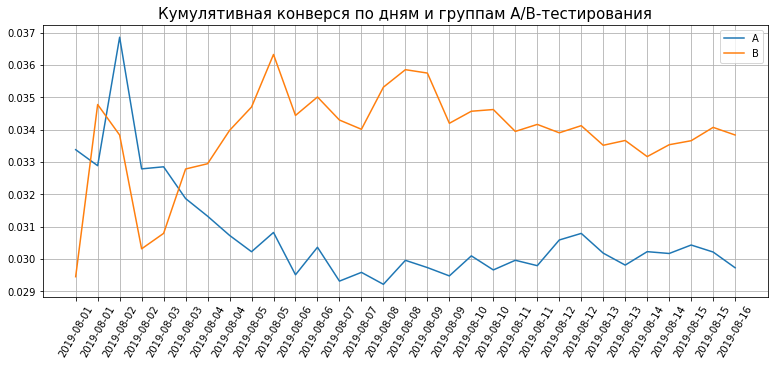

In [17]:
# Построим график кумулятивной конверсии по группам

# считаем кумулятивную конверсию
cummulative_data['conversion'] = cummulative_data['orders']/cummulative_data['visitors']
# отделяем данные по группе A
a_cum_data = cummulative_data[cummulative_data['group']=='A']
# отделяем данные по группе B
b_cum_data = cummulative_data[cummulative_data['group']=='B']

# строим графики
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(a_cum_data['date'], a_cum_data['conversion'], label='A')
ax.plot(b_cum_data['date'], b_cum_data['conversion'], label='B')
ax.set_title('Кумулятивная конверся по дням и группам A/B-тестирования', fontsize=15)
ax.set_xticklabels(cummulative_data['date'], rotation=60)
ax.grid(True)
ax.legend();

Группы резко колебались в начале теста, но после 5 августа колебания конверсии по группам стали менее заначительными.  
Конверсия группы A просела и зафиксировалась на уровне между 2.9% и 3.1%.  
Конверсия группы B имеела более широкий размах - от 3.3% до 3.6% - при этом оставаясь выше, чем у группы A. 

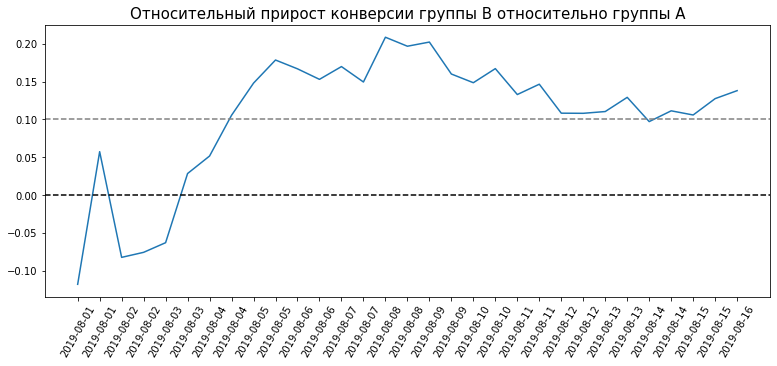

In [18]:
# Построим график относительного изменения кумулятивной конверсии группы B к группе A
cum_conv_merged = a_cum_data[['date','conversion']].merge(b_cum_data[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['_A', '_B'])

fig, ax = plt.subplots(figsize=(13,5))
ax.plot(cum_conv_merged['date'], cum_conv_merged['conversion_B']/cum_conv_merged['conversion_A']-1)
ax.set_title("Относительный прирост конверсии группы B относительно группы A", fontsize=15)
ax.axhline(y=0, color='black', linestyle='--')
ax.axhline(y=0.1, color='grey', linestyle='--')
ax.set_xticklabels(cummulative_data['date'], rotation=60);
#ax.grid(True);


В начале теста группа B  проигрывала группе A, затем вырвалась вперёд. Потом её конверсия снова падала, но теперь колеблется не так значительно.

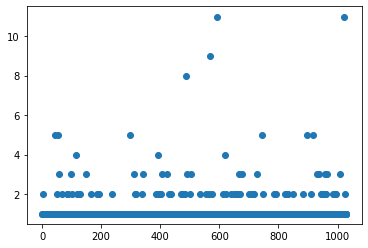

In [19]:
# Почтроим точечный график количества заказов по пользователям

orders_by_user = (orders.groupby(['visitorId'])['transactionId'].count()).reset_index()
orders_by_user.columns = ['visitor', 'orders']

x_values = pd.Series(range(0,len(orders_by_user['orders'])))
plt.scatter(x_values, orders_by_user['orders']);

Большинство покупателей ограничились за время теста 1-2 заказами, некоторые совершили и по 3. Но есть пользователи, заказывающие и до 11 раз. Проверим, относятся ли они к выбросам.

In [20]:
# Выберем границу для определения аномальных пользователей
# Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.
np.percentile(orders_by_user['orders'], [95,99])


array([2., 4.])

Не более 5% покупателей делают больше 2 покупок, а 4 - и вовсе не более 1%.  
Будем считать, что более 2 покупок на пользоватля - аномалия.

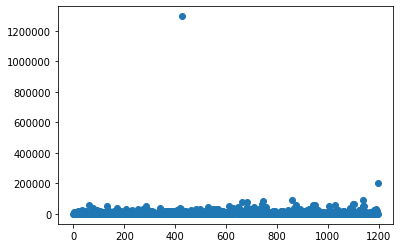

In [21]:
# Построим точечный график стоимостей заказов
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']);

In [22]:
# Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.
np.percentile(orders['revenue'],[95,99])

array([28000. , 58233.2])

Не более 5% покупок делается на сумму более 28,000 руб., и меньше 1% - на сумму выше 58,233.2 руб.  
Примем 5% за границу аномалий, будем считать, что заказы дороже 28,000 - артефакты.

In [23]:
# Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

# сначала, состваим таблицу с данными о результатах в группах A и B

# посчитаем число посетителей магазина в день в группе А
a_visitors_daily = visitors[visitors['group']=='A'][['date', 'visitors']]
a_visitors_daily.columns = ['date', 'visitors_daily_a']
# посчитаем кумулятивное число посетителей магазина в день в группе А
a_visitors_cum = a_visitors_daily.apply(lambda x: a_visitors_daily[a_visitors_daily['date'] <= x['date']]\
                                        .agg({'date' : 'max', 'visitors_daily_a' : 'sum'}), axis=1)
a_visitors_cum.columns = ['date', 'visitors_cummulative_a']
# посчитаем число посетителей магазина в день в группе B
b_visitors_daily = visitors[visitors['group']=='B'][['date', 'visitors']]
b_visitors_daily.columns = ['date', 'visitors_daily_b']
# посчитаем кумулятивное число посетителей магазина в день в группе B
b_visitors_cum = b_visitors_daily.apply(lambda x: b_visitors_daily[b_visitors_daily['date'] <= x['date']]\
                                        .agg({'date' : 'max', 'visitors_daily_b' : 'sum'}), axis=1)
b_visitors_cum.columns = ['date', 'visitors_cummulative_b']
# рассчитаем число покупателей и покупок в группе А за день
a_orders_daily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
a_orders_daily.columns = ['date', 'a_orders_daily', 'a_rev_per_day']
# рассчитаем число покупателей и покупок в группе А кумулированых по дням 
a_orders_cum = a_orders_daily.apply(
    lambda x: \
        a_orders_daily[a_orders_daily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'a_orders_daily' : 'sum',
                'a_rev_per_day' : 'sum'}), axis=1).sort_values(by=['date'])
a_orders_cum.columns = ['date', 'a_orders_cum', 'a_rev_cum']
# рассчитаем число покупателей и покупок в группе B за день
b_orders_daily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
b_orders_daily.columns = ['date', 'b_orders_daily', 'b_rev_per_day']
# рассчитаем число покупателей и покупок в группе B кумулированых по дням 
b_orders_cum = b_orders_daily.apply(
    lambda x: \
        b_orders_daily[b_orders_daily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'b_orders_daily' : 'sum',
                'b_rev_per_day' : 'sum'}), axis=1).sort_values(by=['date'])
b_orders_cum.columns = ['date', 'b_orders_cum', 'b_rev_cum']
# объединим полученные данные в одну таблицу
data = a_orders_daily.merge(b_orders_daily, left_on='date', right_on='date', how='left')\
    .merge(a_orders_cum, left_on='date', right_on='date', how='left')\
    .merge(b_orders_cum, left_on='date', right_on='date', how='left')\
    .merge(a_visitors_daily, left_on='date', right_on='date', how='left')\
    .merge(b_visitors_daily, left_on='date', right_on='date', how='left')\
    .merge(a_visitors_cum, left_on='date', right_on='date', how='left')\
    .merge(b_visitors_cum, left_on='date', right_on='date', how='left')

data.head(5)

,date,a_orders_daily,a_rev_per_day,b_orders_daily,b_rev_per_day,a_orders_cum,a_rev_cum,b_orders_cum,b_rev_cum,visitors_daily_a,visitors_daily_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [24]:
# Создадим таблицы с пользователями, которые заказывали хотя бы 1 раз и числом совершённых ими заказов, отдельно для групп A и B
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByUsersB.columns = ['userId', 'orders']

# Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов
sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(data['visitors_daily_a'].sum() - len(ordersByUsersA['orders'])), 
                               name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(data['visitors_daily_b'].sum() - len(ordersByUsersB['orders'])), 
                               name='orders')],axis=0)

# посчитаем p-value тестом Манна-Уитни и проверим гипотезу о равенстве конверсий групп
p_value = stats.mannwhitneyu(sampleA, sampleB)[1]
print('p-value:',"{0:.3f}".format(p_value))
if p_value > 0.05:
    print('Нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем.')
else:
    print('Отвергаем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет.')
# Выведем относительный прирост конверсии группы B:
print('Относительный прирост конверсии группы B:',"{0:.0%}".format(sampleB.mean()/sampleA.mean()-1))

p-value: 0.008
Отвергаем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет.
Относительный прирост конверсии группы B: 14%


По «сырым» данным между конверсиями групп есть статистически значимые различия. Конверсия группы B выше на 14%.

In [25]:
# Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным 
p_value_rev = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
revenue_difference = orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1
print('p-value: {0:.3f}'.format(p_value_rev))
if p_value_rev > 0.05:
    print('Нулевую гипотезу о том, что статистически значимых различий в среднем чеке между группами нет, не отвергаем.')
else:
    print('Отвергаем нулевую гипотезу о том, что статистически значимых различий в  среднем чеке  между группами нет.')
print('Относительные различия в среднем чеке между группами: {0:.0%}.'.format(revenue_difference))

p-value: 0.365
Нулевую гипотезу о том, что статистически значимых различий в среднем чеке между группами нет, не отвергаем.
Относительные различия в среднем чеке между группами: 26%.


По «сырым» данным в среднем чеке нет статистически значимых различий (p-value значительно больше 5%).  
Средний чек в группе B на 26% больше, чем в группе A.

In [26]:
# Ранее мы приняли за аномальных пользователей тех, кто совершил от 3 покупок или совершил заказ дороже 28,000 рублей. 
# Составим срез с пользователями, представляющими эти аномалии:
abnormal_orders_number = pd.concat([ordersByUsersA[ordersByUsersA['orders'] >= 3]['userId'], 
                                 ordersByUsersB[ordersByUsersB['orders'] >= 3]['userId']], axis = 0)
abnormal_orders_value = orders[orders['revenue'] > 28000]['visitorId']
abnormal_users = pd.concat([abnormal_orders_number, abnormal_orders_value], axis = 0).drop_duplicates().sort_values()
print('Число аномалий:', len(abnormal_users)) # посчитаем таких пользователей

Число аномалий: 74


In [27]:
# Узнаем, как аномальные действия повлияли на результаты теста - 
# посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. 

# Сначала подготовим выборки количества заказов по пользователям по группам теста:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormal_users))]['orders'],
                             pd.Series(0, index=np.arange(data['visitors_daily_a'].sum() \
                                                          - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormal_users))]['orders'],
                             pd.Series(0, index=np.arange(data['visitors_daily_b'].sum() \
                                                          - len(ordersByUsersB['orders'])),name='orders')],axis=0)

# Применим статистический критерий Манна-Уитни к полученным выборкам:
p_value_filtered_conv = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
print("P-value: {0:.3f}".format(p_value_filtered_conv))
if p_value_filtered_conv > 0.05:
    print('Нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем.')
else:
    print('Отвергаем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет.')
print("Относительный прирост конверсии группы B (по очиненным данным): {0:.0%}."\
      .format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

P-value: 0.007
Отвергаем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет.
Относительный прирост конверсии группы B (по очиненным данным): 17%.


И по «сырым», и по очищенным от выбросов данным между конверсиями групп есть статистически значимые различия.  
По очищенным данным разница в конверсиях составляет 17% (по "сырым" - 14%, в этом проявлялось влияние выбросов).


In [28]:
# Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным
p_value_rev_filtered = stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'])[1]

revenue_difference_filtered = orders[np.logical_and(orders['group']=='B',
                          np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'].mean()/\
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'].mean() - 1
    
print("P-value: {0:.3f}".format(p_value_rev_filtered))
if p_value_rev_filtered > 0.05:
    print('Нулевую гипотезу о том, что статистически значимых различий в среднем чеке между группами нет, не отвергаем.')
else:
    print('Отвергаем нулевую гипотезу о том, что статистически значимых различий в  среднем чеке  между группами нет.')
print("Относительные различия в среднем чеке между группами (по очиненным данным): {0:.0%}.".format(revenue_difference_filtered))

P-value: 0.369
Нулевую гипотезу о том, что статистически значимых различий в среднем чеке между группами нет, не отвергаем.
Относительные различия в среднем чеке между группами (по очиненным данным): -2%.


И по «сырым», по очищенным от аномалий данным в среднем чеке нет статистически значимых различий.
Однако по очищенным данным чек в группе А на 2% больше, чем в группе B.  
Ситуация в этом показателе, расчитанном по "сырым" данным, была кардинально иной - по "сырым" данным средний чек в группе B на 26% больше, чем в группе A. Это демонстрирует, насколько влияние аномалий влияет на результат теста.

#### Примем решение по результатам теста
Имеющиеся факты:
- И по «сырым», и по очищенным от выбросов данным между конверсиями групп есть статистически значимые различия. По очищенным данным разница в конверсиях составляет 17% (по "сырым" - 14%, в этом проявлялось влияние выбросов) в пользу группы B.
- И по «сырым», по очищенным от аномалий данным в среднем чеке нет статистически значимых различий. По очищенным данным чек в группе А на 2% больше, чем в группе B (по "сырым" данным средний чек в группе B на 26% больше, чем в группе A) Видим, что выбросы действительно значительно влияют на результаты теста.

**Принимаем решения остановить тест и зафиксировать победу групы B по показателю конверсии.**


## 4. Общий вывод  <a name='conclusion'></a>

### Приоритезация гипотез
Мы провели оценку гипотез по фреймворкам ICE и RICE и отобрали две наиболее перспективные:  
**- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**;  
**- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей**.  

---
### Анализ результатов A/B теста
Также мы провели анализ A/B теста, проведенного на посетителях интернет-магазина с 1 по 16 августа.  

В обеих группах **выручка** почти равномерно увеличивалась в течение всего теста.  
После 3 августа куммулятивная **выручка в группе B стала превосходить выручку группы А**.  
К 7 августа их показатели сравнялись из-за рывка в группе A в течение 6-7 августа. Однако после этого скачки в росте выручки группы B (в особенности произошедший 9 августа) закрепили превосходство показателя группы B. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. *Такие аномалии могут повлиять на результат теста, поэтому мы изучили их отдельно*.  

**Средний чек** в обеих группах колеблется и растет до 7-9 августа.  
Для группы A средний чек более или менее установился после 7 августа в районе около 7,000 руб., дальнейшие колебания не сильные.
9 августа в группе B произошел резкий скачок показателя, после этого он стал немного снижаться, хотя куммулятивная метрика осталась выше, чем у группы А. Возможно, в группу B в этот день попали крупные заказы. Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.  
К 16 августа **средний чек группы B выше, чем у группы A**.  

Относительная разница среднего чека со второго дня эксперемента была на стороне группы B, за исключением периода между 5 и 9 августа. Опять же виден *скачок 9 августа*.  

Показатели **конверсии** обеих групп резко колебались в начале теста, но после 5 августа эти колебания стали менее заначительными.  
Конверсия группы A просела и зафиксировалась на уровне между 2.9% и 3.1%.  
**Конверсия группы B** имеела более широкий размах - от 3.3% до 3.6% - при этом оставаясь **выше, чем у группы A**.  
В начале теста группа B проигрывала группе A, затем вырвалась вперёд. Потом её конверсия снова падала, но теперь колеблется не так значительно.  

Проанализировав количество заказов, которые делает каждый пользователь, и суммы заказов, мы определили **границы аномалий**. 
Решено,что **более 2 покупок на пользоватля и заказы дороже 28,000 - артефакты**. Такие значения встречаются в менее чем 5% случаев. Число аномалий: 74.  

Мы применили тест Манна-Уитни к показателям, рассчитанным по "сырым" и очищенным данным для проверку на наличие статистически значимых различий.
- И по «сырым», и по очищенным от выбросов данным между конверсиями групп есть статистически значимые различия. По очищенным данным разница в конверсиях составляет 17% (по "сырым" - 14%, в этом проявлялось влияние выбросов) в пользу группы B.  
- И по «сырым», по очищенным от аномалий данным в среднем чеке нет статистически значимых различий. По очищенным данным чек в группе А на 2% больше, чем в группе B (по "сырым" данным средний чек в группе B на 26% больше, чем в группе A)
Видим, что выбросы действительно значительно влияют на результаты теста.  

Однако, показатель конверсии группы B определенно превосходит конверсию группы А. По показателю же размера среднего чека статистически значимых различий в результатах двух групп не выявлено.  
Исходя их обнаруженных фактов, **тест следует остановить и зафиксировать победу групы B по показателю конверсии.**.